# Week 4: Financial Data & Portfolio Theory

## 🎯 Learning Objectives

By the end of this week, you will understand:
- **Financial Returns**: Simple vs log returns and when to use each
- **Risk Measures**: VaR, CVaR, Maximum Drawdown
- **Risk-Adjusted Returns**: Sharpe, Sortino, Calmar ratios
- **Modern Portfolio Theory**: Diversification and optimization
- **CAPM**: Beta, alpha, and systematic risk

---

## Why This Matters

Portfolio theory is the foundation of:
- Asset allocation strategies
- Risk management frameworks
- Performance evaluation
- Factor investing

Understanding these concepts is **essential** for any quant role!

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, linregress
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

# Constants
TRADING_DAYS = 252

print("✅ Libraries loaded successfully!")
print("📚 Week 4: Financial Data & Portfolio Theory")
print(f"📅 Trading days per year: {TRADING_DAYS}")

✅ Libraries loaded successfully!
📚 Week 4: Financial Data & Portfolio Theory
📅 Trading days per year: 252


---

# Part 1: Types of Financial Returns

## Simple (Arithmetic) Returns

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

**Properties**:
- Easy to interpret (percentage change)
- **Cross-sectionally additive**: Portfolio return = weighted sum of asset returns
- NOT time-additive

## Log (Continuously Compounded) Returns

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

**Properties**:
- **Time-additive**: $r_{t_1 \to t_n} = r_1 + r_2 + ... + r_n$
- More symmetric for gains/losses
- Preferred for statistical modeling

## When to Use Which?

| Situation | Use |
|-----------|-----|
| Statistical modeling | Log returns |
| Portfolio returns | Simple returns |
| Performance reporting | Simple returns |
| Risk modeling | Log returns |

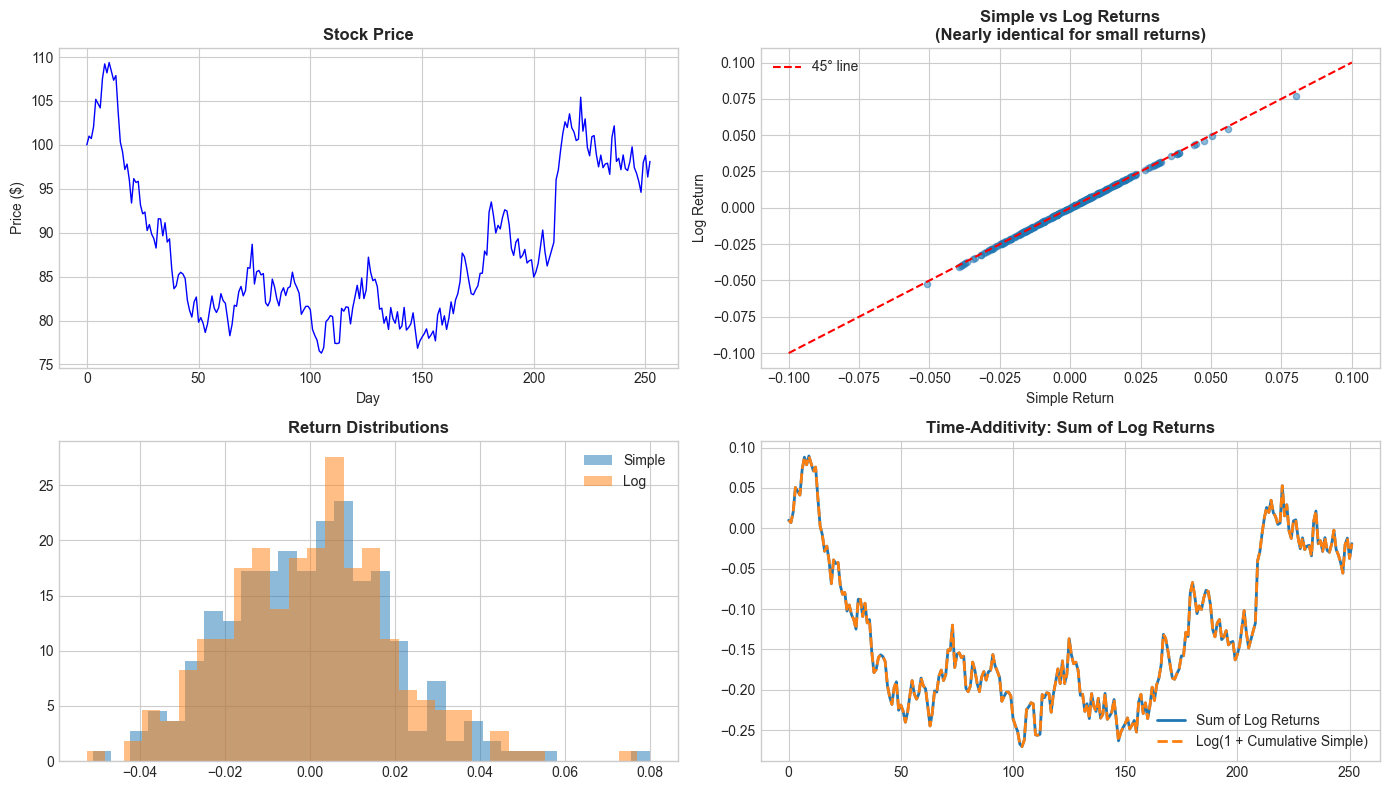


📊 RETURN COMPARISON:
Metric                             Simple             Log
------------------------------------------------------------
Mean (daily)                      0.0111%        -0.0075%
Std Dev (daily)                   1.9367%         1.9306%
Total Return                     -1.8796%        -1.8975%
Correlation                        0.9999

📊 OUTPUT EXPLANATION:
• Scatter plot: Simple ≈ Log for small returns (|r| < 10%)
• Distributions are nearly identical
• Log returns SUM to give total log return
• Simple returns must be COMPOUNDED: (1+r₁)(1+r₂)...(1+rₙ)-1


In [2]:
# Demonstrate the difference between simple and log returns
np.random.seed(42)

# Simulate price series
n_days = 252
daily_log_returns = np.random.randn(n_days) * 0.02  # ~2% daily vol
prices = 100 * np.exp(np.cumsum(daily_log_returns))  # Start at $100
prices = np.insert(prices, 0, 100)  # Add starting price

# Calculate both types of returns
simple_returns = np.diff(prices) / prices[:-1]
log_returns = np.diff(np.log(prices))

# Compare
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Price series
axes[0, 0].plot(prices, 'b-', linewidth=1)
axes[0, 0].set_title('Stock Price', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_xlabel('Day')

# Simple vs Log returns
axes[0, 1].scatter(simple_returns, log_returns, alpha=0.5, s=20)
axes[0, 1].plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='45° line')
axes[0, 1].set_xlabel('Simple Return')
axes[0, 1].set_ylabel('Log Return')
axes[0, 1].set_title('Simple vs Log Returns\n(Nearly identical for small returns)', fontweight='bold')
axes[0, 1].legend()

# Distribution comparison
axes[1, 0].hist(simple_returns, bins=30, alpha=0.5, label='Simple', density=True)
axes[1, 0].hist(log_returns, bins=30, alpha=0.5, label='Log', density=True)
axes[1, 0].set_title('Return Distributions', fontweight='bold')
axes[1, 0].legend()

# Time-additivity demonstration
cumsum_log = np.cumsum(log_returns)
cumprod_simple = np.cumprod(1 + simple_returns) - 1
axes[1, 1].plot(cumsum_log, label='Sum of Log Returns', linewidth=2)
axes[1, 1].plot(np.log(1 + cumprod_simple), '--', label='Log(1 + Cumulative Simple)', linewidth=2)
axes[1, 1].set_title('Time-Additivity: Sum of Log Returns', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 RETURN COMPARISON:")
print("="*60)
print(f"{'Metric':<25} {'Simple':>15} {'Log':>15}")
print("-"*60)
print(f"{'Mean (daily)':<25} {simple_returns.mean():>15.4%} {log_returns.mean():>15.4%}")
print(f"{'Std Dev (daily)':<25} {simple_returns.std():>15.4%} {log_returns.std():>15.4%}")
print(f"{'Total Return':<25} {(prices[-1]/prices[0]-1):>15.4%} {np.sum(log_returns):>15.4%}")
print(f"{'Correlation':<25} {np.corrcoef(simple_returns, log_returns)[0,1]:>15.4f}")

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Scatter plot: Simple ≈ Log for small returns (|r| < 10%)")
print("• Distributions are nearly identical")
print("• Log returns SUM to give total log return")
print("• Simple returns must be COMPOUNDED: (1+r₁)(1+r₂)...(1+rₙ)-1")

In [3]:
# Annualization formulas
def annualize_return(daily_returns, method='geometric'):
    """Annualize daily returns."""
    if method == 'geometric':
        return (1 + daily_returns.mean()) ** TRADING_DAYS - 1
    else:  # arithmetic
        return daily_returns.mean() * TRADING_DAYS

def annualize_volatility(daily_returns):
    """Annualize daily volatility using square root of time."""
    return daily_returns.std() * np.sqrt(TRADING_DAYS)

# Demonstrate annualization
daily_mean = simple_returns.mean()
daily_std = simple_returns.std()

print("ANNUALIZATION FORMULAS")
print("="*60)
print(f"\n📈 Return Annualization:")
print(f"   Daily mean return: {daily_mean:.4%}")
print(f"   Geometric: (1 + r_daily)^252 - 1 = {annualize_return(simple_returns, 'geometric'):.2%}")
print(f"   Arithmetic: r_daily × 252 = {annualize_return(simple_returns, 'arithmetic'):.2%}")

print(f"\n📊 Volatility Annualization (Square Root of Time):")
print(f"   Daily volatility: {daily_std:.4%}")
print(f"   Annual: σ_daily × √252 = {annualize_volatility(simple_returns):.2%}")

print("\n💡 WHY SQUARE ROOT OF TIME?")
print("   For independent returns: Var(sum) = sum of Var")
print("   Annual Var = 252 × Daily Var")
print("   Annual Std = √(252 × Daily Var) = √252 × Daily Std")

ANNUALIZATION FORMULAS

📈 Return Annualization:
   Daily mean return: 0.0111%
   Geometric: (1 + r_daily)^252 - 1 = 2.85%
   Arithmetic: r_daily × 252 = 2.81%

📊 Volatility Annualization (Square Root of Time):
   Daily volatility: 1.9367%
   Annual: σ_daily × √252 = 30.74%

💡 WHY SQUARE ROOT OF TIME?
   For independent returns: Var(sum) = sum of Var
   Annual Var = 252 × Daily Var
   Annual Std = √(252 × Daily Var) = √252 × Daily Std


---

# Part 2: Risk Measures

## Volatility (Standard Deviation)

$$\sigma = \sqrt{\frac{1}{n-1}\sum_{t=1}^{n}(r_t - \bar{r})^2}$$

**Limitation**: Treats upside and downside equally!

## Value at Risk (VaR)

Maximum loss at a given confidence level.

$$VaR_{\alpha} = -\text{Quantile}_{1-\alpha}(R)$$

**Example**: 95% VaR = 3% means "5% chance of losing more than 3%"

## Conditional VaR (CVaR / Expected Shortfall)

Average loss when VaR is exceeded.

$$CVaR_{\alpha} = E[R | R < -VaR_{\alpha}]$$

**Better than VaR** because it measures severity of tail losses.

## Maximum Drawdown

$$MDD = \max_t\left(\frac{\text{Peak}_t - \text{Value}_t}{\text{Peak}_t}\right)$$

Largest peak-to-trough decline.

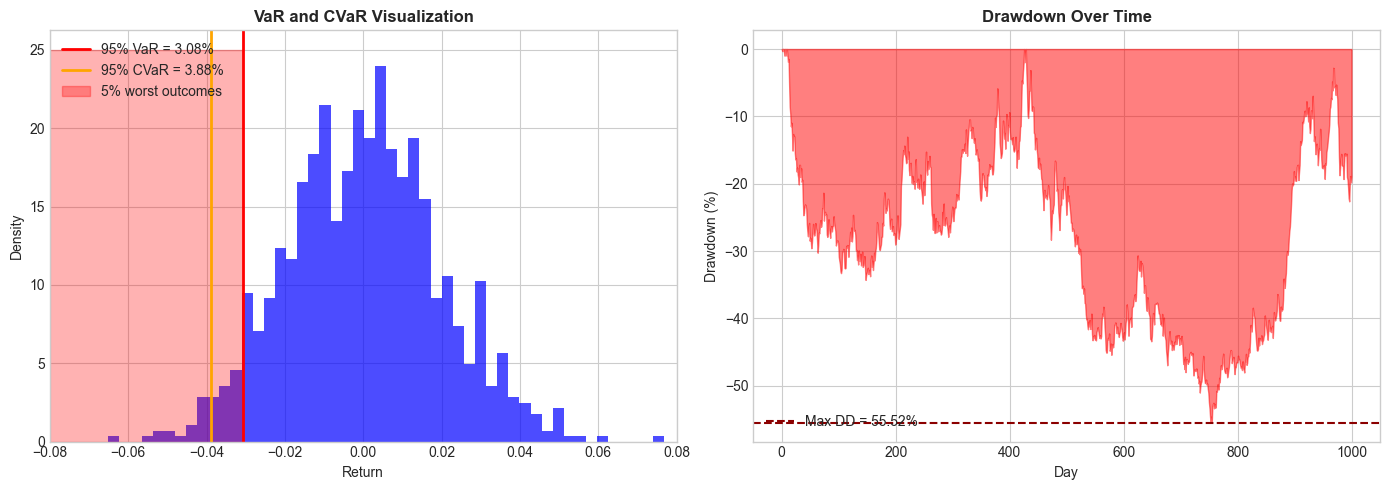


📊 RISK MEASURES SUMMARY:
Metric                                   Value
------------------------------------------------------------
Daily Volatility                         1.96%
Annual Volatility                       31.07%
95% VaR (Historical)                     3.08%
95% VaR (Parametric)                     3.21%
99% VaR (Historical)                     4.19%
95% CVaR (Expected Shortfall)            3.88%
Maximum Drawdown                        55.52%

📊 OUTPUT EXPLANATION:
• VaR: 'With 95% confidence, daily loss won't exceed this'
• CVaR: 'If we're in the worst 5%, average loss is this'
• CVaR > VaR always (measures tail severity)
• Max DD: Worst peak-to-trough decline experienced

⚠️  VaR doesn't tell you HOW BAD the worst 5% can be!


In [4]:
# Risk measure calculations
def calculate_var(returns, confidence=0.95):
    """Calculate historical VaR."""
    return -np.percentile(returns, (1 - confidence) * 100)

def calculate_parametric_var(returns, confidence=0.95):
    """Calculate parametric VaR assuming normal distribution."""
    mu, sigma = returns.mean(), returns.std()
    z = norm.ppf(1 - confidence)
    return -(mu + z * sigma)

def calculate_cvar(returns, confidence=0.95):
    """Calculate Conditional VaR (Expected Shortfall)."""
    var = calculate_var(returns, confidence)
    return -returns[returns <= -var].mean()

def calculate_max_drawdown(returns):
    """Calculate maximum drawdown from returns."""
    cumulative = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (running_max - cumulative) / running_max
    return drawdown.max()

# Generate returns for demonstration
np.random.seed(42)
n = 1000
returns_demo = np.random.randn(n) * 0.02 - 0.0003  # Slight negative drift

# Calculate all risk measures
volatility = returns_demo.std()
var_95 = calculate_var(returns_demo, 0.95)
var_99 = calculate_var(returns_demo, 0.99)
pvar_95 = calculate_parametric_var(returns_demo, 0.95)
cvar_95 = calculate_cvar(returns_demo, 0.95)
max_dd = calculate_max_drawdown(returns_demo)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution with VaR/CVaR
axes[0].hist(returns_demo, bins=50, density=True, alpha=0.7, color='blue')
axes[0].axvline(x=-var_95, color='red', linewidth=2, label=f'95% VaR = {var_95:.2%}')
axes[0].axvline(x=-cvar_95, color='orange', linewidth=2, label=f'95% CVaR = {cvar_95:.2%}')
axes[0].fill_betweenx([0, 25], -0.1, -var_95, alpha=0.3, color='red', label='5% worst outcomes')
axes[0].set_xlim(-0.08, 0.08)
axes[0].set_title('VaR and CVaR Visualization', fontweight='bold')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Density')
axes[0].legend(loc='upper left')

# Drawdown chart
cumulative = (1 + returns_demo).cumprod()
running_max = np.maximum.accumulate(cumulative)
drawdown = (running_max - cumulative) / running_max

axes[1].fill_between(range(len(drawdown)), 0, -drawdown * 100, color='red', alpha=0.5)
axes[1].axhline(y=-max_dd * 100, color='darkred', linestyle='--', label=f'Max DD = {max_dd:.2%}')
axes[1].set_title('Drawdown Over Time', fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Drawdown (%)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Summary
print("\n📊 RISK MEASURES SUMMARY:")
print("="*60)
print(f"{'Metric':<30} {'Value':>15}")
print("-"*60)
print(f"{'Daily Volatility':<30} {volatility:>15.2%}")
print(f"{'Annual Volatility':<30} {volatility * np.sqrt(252):>15.2%}")
print(f"{'95% VaR (Historical)':<30} {var_95:>15.2%}")
print(f"{'95% VaR (Parametric)':<30} {pvar_95:>15.2%}")
print(f"{'99% VaR (Historical)':<30} {var_99:>15.2%}")
print(f"{'95% CVaR (Expected Shortfall)':<30} {cvar_95:>15.2%}")
print(f"{'Maximum Drawdown':<30} {max_dd:>15.2%}")

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• VaR: 'With 95% confidence, daily loss won't exceed this'")
print("• CVaR: 'If we're in the worst 5%, average loss is this'")
print("• CVaR > VaR always (measures tail severity)")
print("• Max DD: Worst peak-to-trough decline experienced")
print("\n⚠️  VaR doesn't tell you HOW BAD the worst 5% can be!")

---

# Part 3: Risk-Adjusted Return Measures

## Sharpe Ratio

$$SR = \frac{E[R_p - R_f]}{\sigma_p}$$

**Annualized**: $SR_{annual} = \frac{\bar{R} - R_f}{\sigma} \times \sqrt{252}$

## Sortino Ratio

$$Sortino = \frac{R_p - R_f}{\sigma_{downside}}$$

Uses **downside deviation** instead of total volatility.

## Calmar Ratio

$$Calmar = \frac{R_{annual}}{|MDD|}$$

Return relative to worst drawdown.

## Information Ratio

$$IR = \frac{R_p - R_b}{\sigma_{tracking}}$$

Excess return over benchmark per unit of tracking error.

In [5]:
# Risk-adjusted return calculations
def sharpe_ratio(returns, rf=0):
    """Calculate annualized Sharpe ratio."""
    excess = returns - rf / TRADING_DAYS
    return np.sqrt(TRADING_DAYS) * excess.mean() / excess.std()

def sortino_ratio(returns, rf=0, target=0):
    """Calculate annualized Sortino ratio."""
    excess = returns - rf / TRADING_DAYS
    downside = returns[returns < target]
    downside_std = np.sqrt(np.mean(downside**2)) if len(downside) > 0 else 0
    return np.sqrt(TRADING_DAYS) * excess.mean() / downside_std if downside_std > 0 else np.inf

def calmar_ratio(returns):
    """Calculate Calmar ratio."""
    annual_return = (1 + returns.mean()) ** TRADING_DAYS - 1
    max_dd = calculate_max_drawdown(returns)
    return annual_return / max_dd if max_dd > 0 else np.inf

def information_ratio(portfolio_returns, benchmark_returns):
    """Calculate Information ratio."""
    excess = portfolio_returns - benchmark_returns
    return np.sqrt(TRADING_DAYS) * excess.mean() / excess.std()

# Generate sample strategies
np.random.seed(42)
n = 500

# Strategy A: Low volatility, moderate return
strat_a = np.random.randn(n) * 0.008 + 0.0003

# Strategy B: High volatility, higher return
strat_b = np.random.randn(n) * 0.02 + 0.0006

# Strategy C: Asymmetric (negative skew)
strat_c = np.where(np.random.rand(n) > 0.95, 
                   np.random.randn(n) * 0.05 - 0.03,  # Rare big losses
                   np.random.randn(n) * 0.005 + 0.0004)  # Small gains

# Benchmark
benchmark = np.random.randn(n) * 0.012 + 0.0004

strategies = {'Strategy A': strat_a, 'Strategy B': strat_b, 'Strategy C': strat_c}

# Calculate metrics for all strategies
print("RISK-ADJUSTED PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<20} {'Strategy A':>15} {'Strategy B':>15} {'Strategy C':>15}")
print("-"*70)

for name, rets in strategies.items():
    ann_ret = (1 + rets.mean()) ** TRADING_DAYS - 1
    print(f"{'Annual Return':<20} {ann_ret:>14.2%}" if name == 'Strategy A' else "", end="")

print(f"{'Annual Return':<20}", end="")
for name, rets in strategies.items():
    ann_ret = (1 + rets.mean()) ** TRADING_DAYS - 1
    print(f" {ann_ret:>14.2%}", end="")
print()

print(f"{'Annual Volatility':<20}", end="")
for name, rets in strategies.items():
    ann_vol = rets.std() * np.sqrt(TRADING_DAYS)
    print(f" {ann_vol:>14.2%}", end="")
print()

print(f"{'Sharpe Ratio':<20}", end="")
for name, rets in strategies.items():
    sr = sharpe_ratio(rets)
    print(f" {sr:>14.2f}", end="")
print()

print(f"{'Sortino Ratio':<20}", end="")
for name, rets in strategies.items():
    sort = sortino_ratio(rets)
    print(f" {sort:>14.2f}", end="")
print()

print(f"{'Max Drawdown':<20}", end="")
for name, rets in strategies.items():
    mdd = calculate_max_drawdown(rets)
    print(f" {mdd:>14.2%}", end="")
print()

print(f"{'Calmar Ratio':<20}", end="")
for name, rets in strategies.items():
    calm = calmar_ratio(rets)
    print(f" {calm:>14.2f}", end="")
print()

print(f"{'Info Ratio':<20}", end="")
for name, rets in strategies.items():
    ir = information_ratio(rets, benchmark)
    print(f" {ir:>14.2f}", end="")
print()

print("\n📊 OUTPUT EXPLANATION:")
print("="*70)
print("• Strategy A: Lower vol but decent Sharpe - consistent performance")
print("• Strategy B: Higher return but also higher volatility")
print("• Strategy C: Looks OK on Sharpe but terrible Sortino/Calmar!")
print("\n⚠️  Sortino detects asymmetric risk that Sharpe misses!")
print("⚠️  Calmar shows Strategy C has poor drawdown characteristics!")

RISK-ADJUSTED PERFORMANCE COMPARISON
Metric                    Strategy A      Strategy B      Strategy C
----------------------------------------------------------------------
Annual Return                 9.35%Annual Return                 9.35%         36.54%        -43.76%
Annual Volatility            12.45%         31.02%         25.86%
Sharpe Ratio                   0.72           1.00          -2.22
Sortino Ratio                  0.74           1.05          -1.59
Max Drawdown                 11.33%         29.99%         71.18%
Calmar Ratio                   0.83           1.22          -0.61
Info Ratio                    -0.28           0.43          -2.31

📊 OUTPUT EXPLANATION:
• Strategy A: Lower vol but decent Sharpe - consistent performance
• Strategy B: Higher return but also higher volatility
• Strategy C: Looks OK on Sharpe but terrible Sortino/Calmar!

⚠️  Sortino detects asymmetric risk that Sharpe misses!
⚠️  Calmar shows Strategy C has poor drawdown characteristics!

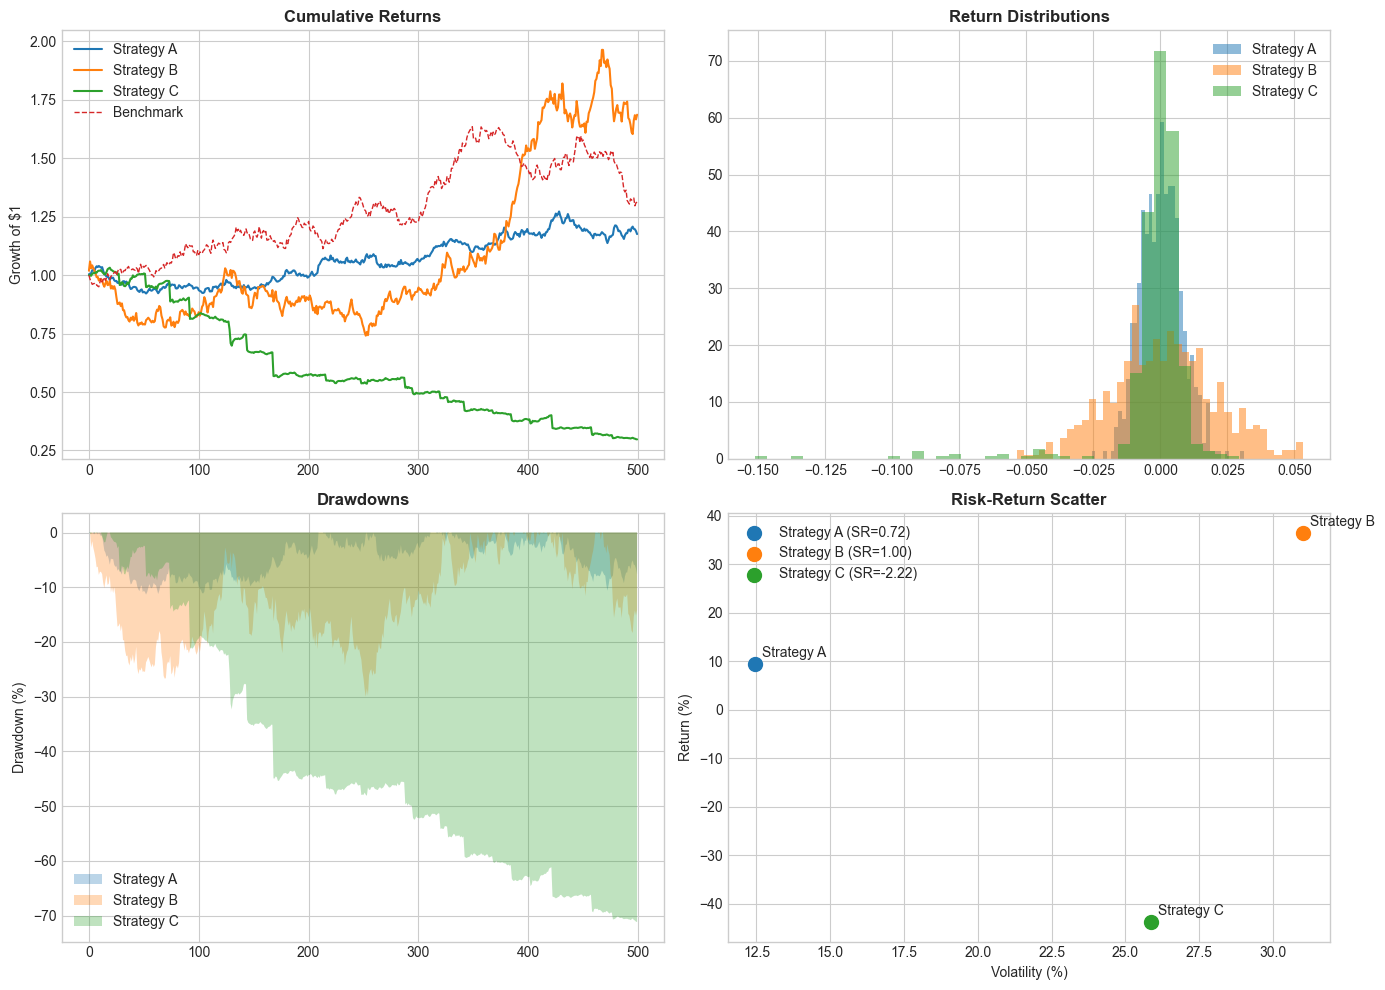

In [6]:
# Visualize cumulative returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
for name, rets in strategies.items():
    cumret = (1 + rets).cumprod()
    axes[0, 0].plot(cumret, label=name, linewidth=1.5)
axes[0, 0].plot((1 + benchmark).cumprod(), '--', label='Benchmark', linewidth=1)
axes[0, 0].set_title('Cumulative Returns', fontweight='bold')
axes[0, 0].set_ylabel('Growth of $1')
axes[0, 0].legend()

# Return distributions
for name, rets in strategies.items():
    axes[0, 1].hist(rets, bins=40, alpha=0.5, label=name, density=True)
axes[0, 1].set_title('Return Distributions', fontweight='bold')
axes[0, 1].legend()

# Drawdowns
for i, (name, rets) in enumerate(strategies.items()):
    cumret = (1 + rets).cumprod()
    running_max = np.maximum.accumulate(cumret)
    dd = (running_max - cumret) / running_max
    axes[1, 0].fill_between(range(len(dd)), -dd*100, alpha=0.3, label=name)
axes[1, 0].set_title('Drawdowns', fontweight='bold')
axes[1, 0].set_ylabel('Drawdown (%)')
axes[1, 0].legend()

# Risk-return scatter
for name, rets in strategies.items():
    ann_ret = (1 + rets.mean()) ** TRADING_DAYS - 1
    ann_vol = rets.std() * np.sqrt(TRADING_DAYS)
    sr = sharpe_ratio(rets)
    axes[1, 1].scatter(ann_vol*100, ann_ret*100, s=100, label=f'{name} (SR={sr:.2f})')
    axes[1, 1].annotate(name, (ann_vol*100, ann_ret*100), textcoords="offset points", xytext=(5,5))

axes[1, 1].set_xlabel('Volatility (%)')
axes[1, 1].set_ylabel('Return (%)')
axes[1, 1].set_title('Risk-Return Scatter', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

---

# Part 4: Modern Portfolio Theory (MPT)

## Harry Markowitz (1952)

**Key Insight**: Don't just maximize returns - consider risk too!

## Portfolio Mathematics

### Portfolio Return
$$R_p = \sum_{i=1}^{n} w_i R_i = \mathbf{w}^T \mathbf{R}$$

### Portfolio Variance
$$\sigma_p^2 = \sum_{i=1}^{n}\sum_{j=1}^{n} w_i w_j \sigma_{ij} = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$$

### For Two Assets:
$$\sigma_p^2 = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2w_1w_2\rho_{12}\sigma_1\sigma_2$$

## The Power of Diversification

If $\rho < 1$, portfolio volatility is LESS than weighted average of individual volatilities!

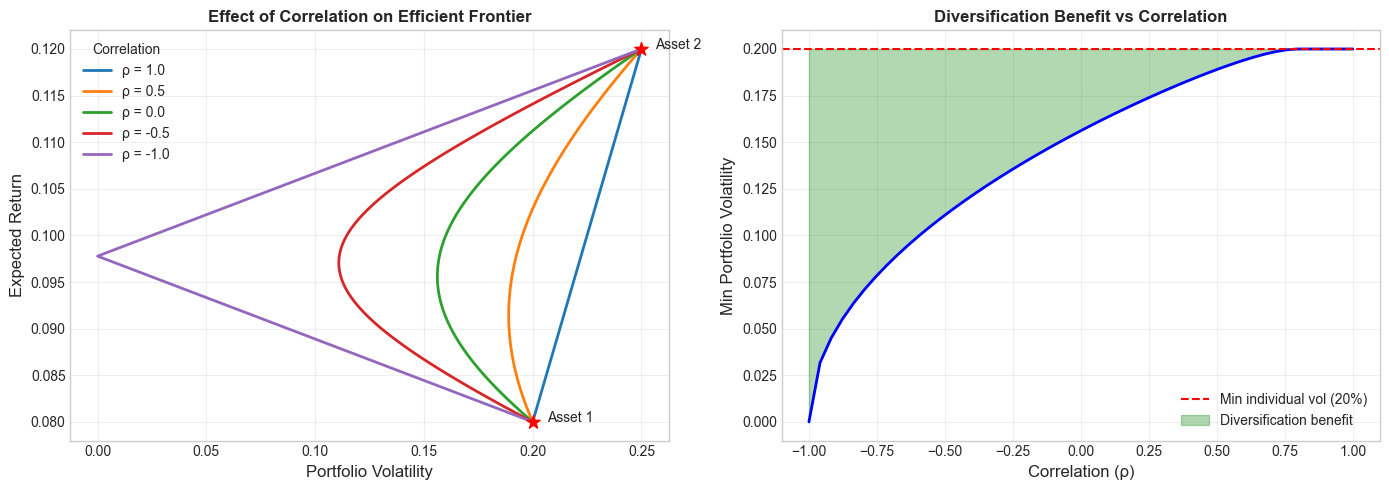


📊 OUTPUT EXPLANATION:
• Left: Lower correlation → More curved frontier → Better diversification
• When ρ = -1, we can achieve ZERO volatility!
• Right: Green area shows how much risk we can eliminate

💡 KEY INSIGHT: Even with positive correlation, diversification helps!


In [7]:
# Demonstrate diversification benefit
def portfolio_variance(w, cov_matrix):
    """Calculate portfolio variance."""
    return w @ cov_matrix @ w

def portfolio_std(w, cov_matrix):
    """Calculate portfolio standard deviation."""
    return np.sqrt(portfolio_variance(w, cov_matrix))

# Two assets with different correlations
sigma1, sigma2 = 0.20, 0.25  # Individual volatilities
mu1, mu2 = 0.08, 0.12  # Expected returns

correlations = [1.0, 0.5, 0.0, -0.5, -1.0]
weights = np.linspace(0, 1, 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for rho in correlations:
    # Covariance matrix
    cov = np.array([[sigma1**2, rho*sigma1*sigma2],
                    [rho*sigma1*sigma2, sigma2**2]])
    
    port_returns = []
    port_vols = []
    
    for w1 in weights:
        w = np.array([w1, 1-w1])
        port_returns.append(w1*mu1 + (1-w1)*mu2)
        port_vols.append(portfolio_std(w, cov))
    
    axes[0].plot(port_vols, port_returns, label=f'ρ = {rho}', linewidth=2)

axes[0].scatter([sigma1, sigma2], [mu1, mu2], s=100, c='red', zorder=5, marker='*')
axes[0].annotate('Asset 1', (sigma1, mu1), textcoords="offset points", xytext=(10,0))
axes[0].annotate('Asset 2', (sigma2, mu2), textcoords="offset points", xytext=(10,0))
axes[0].set_xlabel('Portfolio Volatility', fontsize=12)
axes[0].set_ylabel('Expected Return', fontsize=12)
axes[0].set_title('Effect of Correlation on Efficient Frontier', fontweight='bold')
axes[0].legend(title='Correlation')
axes[0].grid(True, alpha=0.3)

# Show minimum variance for different correlations
min_vols = []
corr_range = np.linspace(-1, 1, 50)
for rho in corr_range:
    cov = np.array([[sigma1**2, rho*sigma1*sigma2],
                    [rho*sigma1*sigma2, sigma2**2]])
    
    # Find minimum variance portfolio
    min_vol = float('inf')
    for w1 in np.linspace(0, 1, 100):
        w = np.array([w1, 1-w1])
        vol = portfolio_std(w, cov)
        if vol < min_vol:
            min_vol = vol
    min_vols.append(min_vol)

axes[1].plot(corr_range, min_vols, 'b-', linewidth=2)
axes[1].axhline(y=min(sigma1, sigma2), color='r', linestyle='--', label=f'Min individual vol ({min(sigma1,sigma2):.0%})')
axes[1].fill_between(corr_range, min_vols, min(sigma1, sigma2), alpha=0.3, color='green', label='Diversification benefit')
axes[1].set_xlabel('Correlation (ρ)', fontsize=12)
axes[1].set_ylabel('Min Portfolio Volatility', fontsize=12)
axes[1].set_title('Diversification Benefit vs Correlation', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Left: Lower correlation → More curved frontier → Better diversification")
print("• When ρ = -1, we can achieve ZERO volatility!")
print("• Right: Green area shows how much risk we can eliminate")
print("\n💡 KEY INSIGHT: Even with positive correlation, diversification helps!")

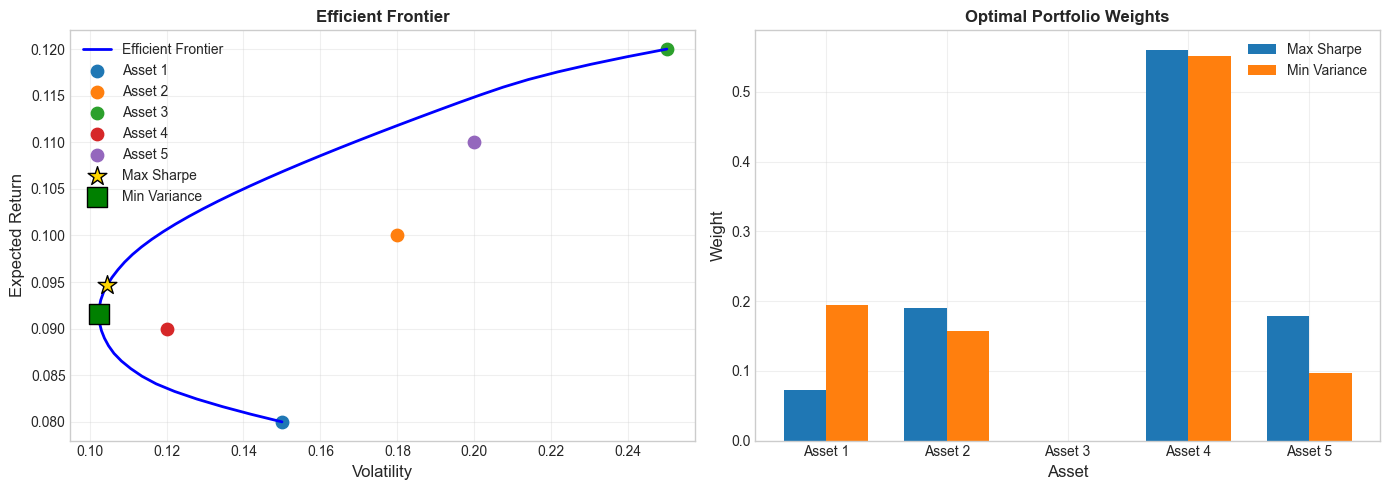


📊 OPTIMAL PORTFOLIO COMPARISON:
Portfolio                  Return   Volatility       Sharpe
------------------------------------------------------------
Max Sharpe                  9.47%       10.47%         0.71
Min Variance                9.16%       10.24%         0.70
Equal Weight               10.00%       12.73%         0.63


In [8]:
# Full portfolio optimization with multiple assets
np.random.seed(42)

# Simulate 5 assets
n_assets = 5
n_days = 500

# Generate correlated returns
expected_returns = np.array([0.08, 0.10, 0.12, 0.09, 0.11])  # Annual
volatilities = np.array([0.15, 0.18, 0.25, 0.12, 0.20])  # Annual

# Correlation matrix
corr_matrix = np.array([
    [1.0, 0.3, 0.2, 0.4, 0.3],
    [0.3, 1.0, 0.5, 0.2, 0.4],
    [0.2, 0.5, 1.0, 0.3, 0.6],
    [0.4, 0.2, 0.3, 1.0, 0.2],
    [0.3, 0.4, 0.6, 0.2, 1.0]
])

# Covariance matrix
cov_matrix = np.outer(volatilities, volatilities) * corr_matrix

# Portfolio optimization functions
def portfolio_return(w, mu):
    return w @ mu

def portfolio_volatility(w, cov):
    return np.sqrt(w @ cov @ w)

def negative_sharpe(w, mu, cov, rf=0.02):
    ret = portfolio_return(w, mu)
    vol = portfolio_volatility(w, cov)
    return -(ret - rf) / vol

# Optimization
n = n_assets
init_weights = np.ones(n) / n
bounds = tuple((0, 1) for _ in range(n))  # Long only
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Maximum Sharpe portfolio
result = minimize(negative_sharpe, init_weights,
                 args=(expected_returns, cov_matrix, 0.02),
                 method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = result.x

# Minimum variance portfolio
result_mv = minimize(lambda w: portfolio_volatility(w, cov_matrix), init_weights,
                    method='SLSQP', bounds=bounds, constraints=constraints)
min_var_weights = result_mv.x

# Generate efficient frontier
target_returns = np.linspace(0.08, 0.12, 50)
frontier_vol = []
frontier_ret = []

for target in target_returns:
    constraints_ef = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w, t=target: portfolio_return(w, expected_returns) - t}
    ]
    result_ef = minimize(lambda w: portfolio_volatility(w, cov_matrix), init_weights,
                        method='SLSQP', bounds=bounds, constraints=constraints_ef)
    if result_ef.success:
        frontier_vol.append(portfolio_volatility(result_ef.x, cov_matrix))
        frontier_ret.append(target)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Efficient frontier
axes[0].plot(frontier_vol, frontier_ret, 'b-', linewidth=2, label='Efficient Frontier')

# Individual assets
for i in range(n_assets):
    axes[0].scatter(volatilities[i], expected_returns[i], s=80, marker='o', label=f'Asset {i+1}')

# Special portfolios
ms_vol = portfolio_volatility(max_sharpe_weights, cov_matrix)
ms_ret = portfolio_return(max_sharpe_weights, expected_returns)
axes[0].scatter(ms_vol, ms_ret, s=200, marker='*', c='gold', edgecolors='black', label='Max Sharpe', zorder=5)

mv_vol = portfolio_volatility(min_var_weights, cov_matrix)
mv_ret = portfolio_return(min_var_weights, expected_returns)
axes[0].scatter(mv_vol, mv_ret, s=200, marker='s', c='green', edgecolors='black', label='Min Variance', zorder=5)

axes[0].set_xlabel('Volatility', fontsize=12)
axes[0].set_ylabel('Expected Return', fontsize=12)
axes[0].set_title('Efficient Frontier', fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Weights bar chart
x = np.arange(n_assets)
width = 0.35
axes[1].bar(x - width/2, max_sharpe_weights, width, label='Max Sharpe')
axes[1].bar(x + width/2, min_var_weights, width, label='Min Variance')
axes[1].set_xlabel('Asset', fontsize=12)
axes[1].set_ylabel('Weight', fontsize=12)
axes[1].set_title('Optimal Portfolio Weights', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Asset {i+1}' for i in range(n_assets)])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print portfolio summary
print("\n📊 OPTIMAL PORTFOLIO COMPARISON:")
print("="*60)
print(f"{'Portfolio':<20} {'Return':>12} {'Volatility':>12} {'Sharpe':>12}")
print("-"*60)
sharpe_ms = (ms_ret - 0.02) / ms_vol
sharpe_mv = (mv_ret - 0.02) / mv_vol
print(f"{'Max Sharpe':<20} {ms_ret:>12.2%} {ms_vol:>12.2%} {sharpe_ms:>12.2f}")
print(f"{'Min Variance':<20} {mv_ret:>12.2%} {mv_vol:>12.2%} {sharpe_mv:>12.2f}")
print(f"{'Equal Weight':<20} {expected_returns.mean():>12.2%} {portfolio_volatility(init_weights, cov_matrix):>12.2%} {(expected_returns.mean()-0.02)/portfolio_volatility(init_weights, cov_matrix):>12.2f}")

---

# Part 5: Capital Asset Pricing Model (CAPM)

## CAPM Formula

$$E[R_i] = R_f + \beta_i (E[R_m] - R_f)$$

Where:
- $E[R_i]$ = Expected return of asset $i$
- $R_f$ = Risk-free rate
- $\beta_i$ = Asset's beta
- $E[R_m] - R_f$ = Market risk premium

## Beta (β)

$$\beta_i = \frac{Cov(R_i, R_m)}{Var(R_m)}$$

**Interpretation**:
- β = 1: Moves with market
- β > 1: More volatile than market (aggressive)
- β < 1: Less volatile than market (defensive)

## Alpha (α) - Jensen's Alpha

$$\alpha_i = R_i - [R_f + \beta_i(R_m - R_f)]$$

Excess return beyond CAPM prediction = **skill** (or luck)

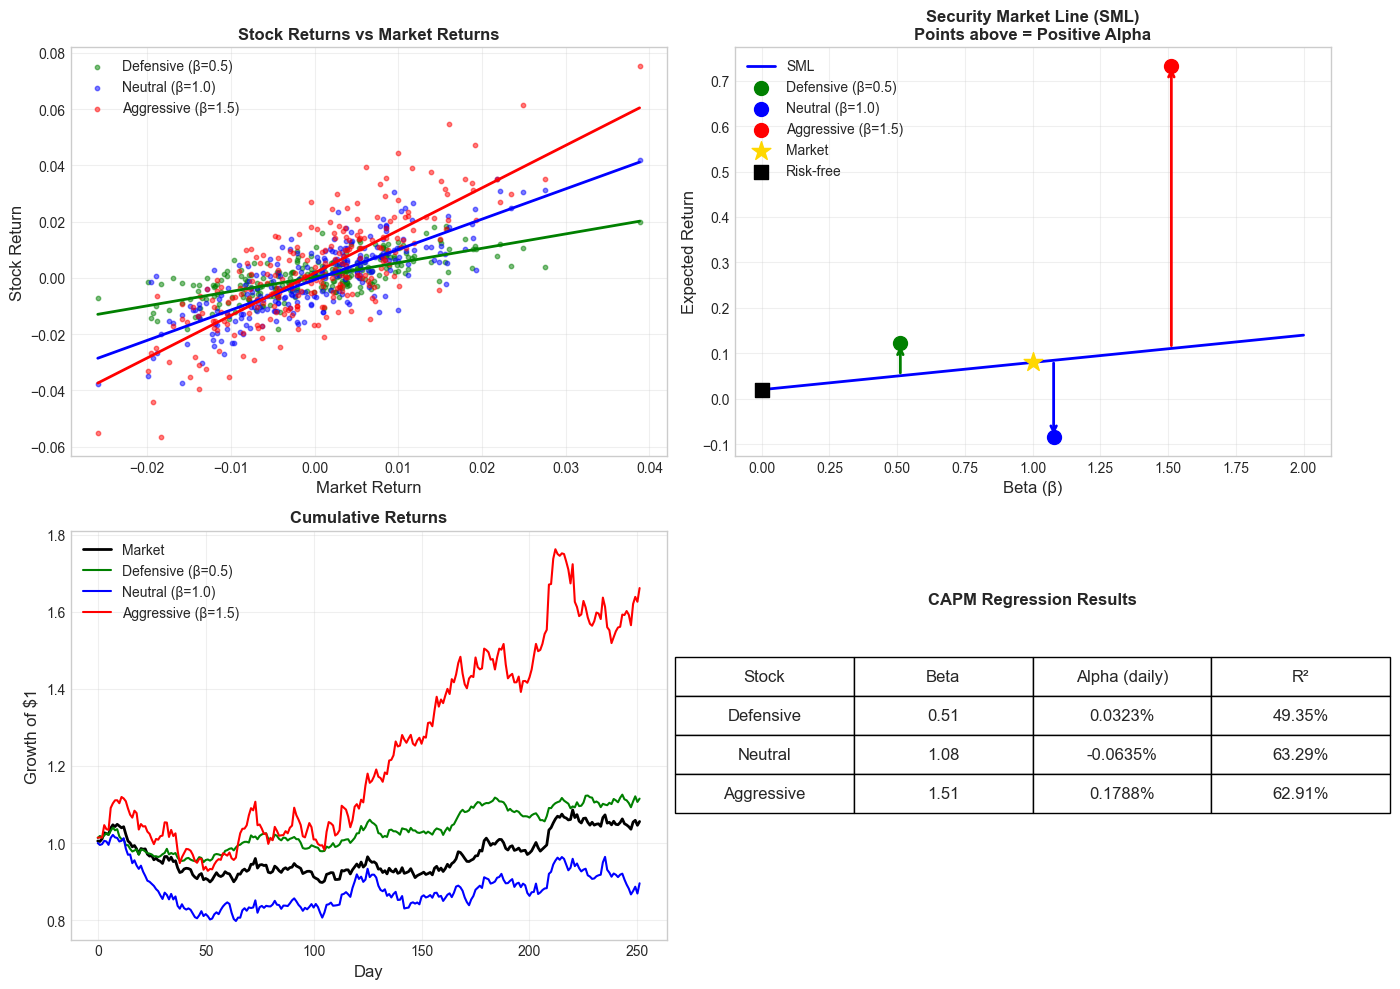


📊 OUTPUT EXPLANATION:
• Top-left: Steeper slope = Higher beta = More market sensitivity
• Top-right: SML shows expected return for each beta level
• Points ABOVE SML have positive alpha (outperformance)
• R² tells us how much return is explained by market

💡 Low R² suggests stock has significant idiosyncratic risk


In [9]:
# CAPM demonstration
np.random.seed(42)
n = 252

# Market returns
market_returns = np.random.randn(n) * 0.01 + 0.0003

# Three stocks with different betas
beta_low = 0.5
beta_mid = 1.0
beta_high = 1.5

alpha_stock = 0.0002  # Positive alpha

# Generate stock returns
stock_low = alpha_stock + beta_low * market_returns + np.random.randn(n) * 0.005
stock_mid = beta_mid * market_returns + np.random.randn(n) * 0.008
stock_high = beta_high * market_returns + np.random.randn(n) * 0.012

def calculate_beta_alpha(stock_returns, market_returns):
    """Calculate beta and alpha using regression."""
    slope, intercept, r_value, p_value, std_err = linregress(market_returns, stock_returns)
    return slope, intercept, r_value**2

# Calculate for each stock
stocks = {
    'Defensive (β=0.5)': stock_low,
    'Neutral (β=1.0)': stock_mid,
    'Aggressive (β=1.5)': stock_high
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plots with regression lines
colors = ['green', 'blue', 'red']
for i, (name, stock_ret) in enumerate(stocks.items()):
    beta, alpha, r2 = calculate_beta_alpha(stock_ret, market_returns)
    
    axes[0, 0].scatter(market_returns, stock_ret, alpha=0.5, s=10, c=colors[i], label=f'{name}')
    
    # Regression line
    x_line = np.array([market_returns.min(), market_returns.max()])
    y_line = alpha + beta * x_line
    axes[0, 0].plot(x_line, y_line, c=colors[i], linewidth=2)

axes[0, 0].set_xlabel('Market Return', fontsize=12)
axes[0, 0].set_ylabel('Stock Return', fontsize=12)
axes[0, 0].set_title('Stock Returns vs Market Returns', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Security Market Line
rf = 0.02  # Risk-free rate
market_premium = 0.06  # Expected market return - rf

betas = np.linspace(0, 2, 100)
expected_returns_sml = rf + betas * market_premium

axes[0, 1].plot(betas, expected_returns_sml, 'b-', linewidth=2, label='SML')

# Plot each stock
for i, (name, stock_ret) in enumerate(stocks.items()):
    beta, alpha, r2 = calculate_beta_alpha(stock_ret, market_returns)
    actual_return = (1 + stock_ret.mean()) ** 252 - 1
    expected = rf + beta * market_premium
    
    axes[0, 1].scatter(beta, actual_return, s=100, c=colors[i], marker='o', label=f'{name}')
    # Arrow showing alpha
    if abs(actual_return - expected) > 0.01:
        axes[0, 1].annotate('', xy=(beta, actual_return), xytext=(beta, expected),
                           arrowprops=dict(arrowstyle='->', color=colors[i], lw=2))

axes[0, 1].scatter(1, rf + market_premium, s=200, c='gold', marker='*', zorder=5, label='Market')
axes[0, 1].scatter(0, rf, s=100, c='black', marker='s', zorder=5, label='Risk-free')
axes[0, 1].set_xlabel('Beta (β)', fontsize=12)
axes[0, 1].set_ylabel('Expected Return', fontsize=12)
axes[0, 1].set_title('Security Market Line (SML)\nPoints above = Positive Alpha', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cumulative returns
axes[1, 0].plot((1 + market_returns).cumprod(), 'k-', linewidth=2, label='Market')
for i, (name, stock_ret) in enumerate(stocks.items()):
    axes[1, 0].plot((1 + stock_ret).cumprod(), c=colors[i], linewidth=1.5, label=name)
axes[1, 0].set_xlabel('Day', fontsize=12)
axes[1, 0].set_ylabel('Growth of $1', fontsize=12)
axes[1, 0].set_title('Cumulative Returns', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Summary table
axes[1, 1].axis('off')
table_data = [['Stock', 'Beta', 'Alpha (daily)', 'R²']]
for name, stock_ret in stocks.items():
    beta, alpha, r2 = calculate_beta_alpha(stock_ret, market_returns)
    table_data.append([name.split('(')[0].strip(), f'{beta:.2f}', f'{alpha:.4%}', f'{r2:.2%}'])

table = axes[1, 1].table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)
axes[1, 1].set_title('CAPM Regression Results', fontweight='bold', y=0.8)

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Top-left: Steeper slope = Higher beta = More market sensitivity")
print("• Top-right: SML shows expected return for each beta level")
print("• Points ABOVE SML have positive alpha (outperformance)")
print("• R² tells us how much return is explained by market")
print("\n💡 Low R² suggests stock has significant idiosyncratic risk")

---

# Summary: Key Formulas

| Concept | Formula |
|---------|--------|
| **Simple Return** | $R_t = P_t/P_{t-1} - 1$ |
| **Log Return** | $r_t = \ln(P_t/P_{t-1})$ |
| **Portfolio Return** | $R_p = \sum w_i R_i$ |
| **Portfolio Variance** | $\sigma_p^2 = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$ |
| **Sharpe Ratio** | $SR = (R_p - R_f) / \sigma_p$ |
| **VaR (95%)** | $-\text{Percentile}_5(R)$ |
| **Beta** | $\beta = Cov(R_i, R_m) / Var(R_m)$ |
| **CAPM** | $E[R_i] = R_f + \beta(E[R_m] - R_f)$ |

## Interview Questions

1. **Why use log returns?** - Time-additive, symmetric, approximately normal
2. **What's wrong with Sharpe ratio?** - Assumes normality, penalizes upside
3. **VaR vs CVaR?** - CVaR measures severity, VaR is just threshold
4. **Why doesn't diversification eliminate all risk?** - Systematic risk remains

In [10]:
# Final summary
print("""
╔══════════════════════════════════════════════════════════════════╗
║        WEEK 4 COMPLETE: FINANCIAL DATA & PORTFOLIO THEORY        ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✓ Part 1: Financial Returns                                    ║
║    • Simple vs Log returns                                      ║
║    • When to use each                                           ║
║    • Annualization formulas                                     ║
║                                                                  ║
║  ✓ Part 2: Risk Measures                                        ║
║    • Volatility, VaR, CVaR                                      ║
║    • Maximum Drawdown                                           ║
║    • Calculated and visualized                                  ║
║                                                                  ║
║  ✓ Part 3: Risk-Adjusted Returns                                ║
║    • Sharpe, Sortino, Calmar ratios                            ║
║    • Information Ratio                                          ║
║    • Compared multiple strategies                               ║
║                                                                  ║
║  ✓ Part 4: Modern Portfolio Theory                              ║
║    • Diversification benefits                                   ║
║    • Efficient Frontier                                         ║
║    • Portfolio optimization                                     ║
║                                                                  ║
║  ✓ Part 5: CAPM                                                 ║
║    • Beta and Alpha calculation                                 ║
║    • Security Market Line                                       ║
║    • Systematic vs Idiosyncratic risk                          ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝

🎯 Foundation Complete! Ready for Advanced Topics!
""")


╔══════════════════════════════════════════════════════════════════╗
║        WEEK 4 COMPLETE: FINANCIAL DATA & PORTFOLIO THEORY        ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✓ Part 1: Financial Returns                                    ║
║    • Simple vs Log returns                                      ║
║    • When to use each                                           ║
║    • Annualization formulas                                     ║
║                                                                  ║
║  ✓ Part 2: Risk Measures                                        ║
║    • Volatility, VaR, CVaR                                      ║
║    • Maximum Drawdown                                           ║
║    • Calculated and visualized                                  ║
║                                                                  ║
║  ✓ Part 3: Risk-Adjusted Returns       